#Import các thư viện cần thiết

In [ ]:
!pip install pyvi

     |████████████████████████████████| 8.5 MB 26.8 MB/s 
     |████████████████████████████████| 743 kB 39.7 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import re
from pyvi import ViTokenizer

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity,linear_kernel

from gensim.models import KeyedVectors
from gensim import models

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from matplotlib import pyplot as plt

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from collections import defaultdict


#Đọc dữ liệu

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/DS300.M11/dataset/vnexpress_news.csv')

In [ ]:
dataset['UserID']

0       1043446290 1070564564 1058227852 1002629270 10...
1                                              1041608906
2             1074373109 1005291929 1005634914 1046496997
3       1057748718 1061840527 1014687651 1003052895 10...
4       1056461424 1065962404 1071937430 1062696358 10...
                              ...                        
6310    1074268383 1028835601 1059803421 1049576733 10...
6311    1002942675 1070849195 1005001771 1054575285 10...
6312    1012746042 1072119819 1003023118 1002657154 10...
6313                                1002679291 1069731719
6314                                           1033920745
Name: UserID, Length: 6315, dtype: object

In [ ]:
Title_length = []
for title in dataset['NewsTitle']:
  length = ViTokenizer.tokenize(title)
  length = len(length.split())
  Title_length.append(length)

Abstract_length = []
for abs in dataset['NewsAbstract']:
  length = ViTokenizer.tokenize(abs)
  length = len(length.split())
  Abstract_length.append(length)


(array([  28.,  323., 1198., 1974., 1619.,  839.,  273.,   51.,    6.,
           4.]),
 array([ 3. ,  4.9,  6.8,  8.7, 10.6, 12.5, 14.4, 16.3, 18.2, 20.1, 22. ]),
 <a list of 10 Patch objects>)

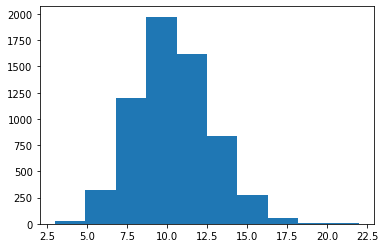

In [ ]:
plt.hist(Title_length)

(array([3.200e+01, 3.490e+02, 1.293e+03, 2.261e+03, 1.566e+03, 6.030e+02,
        1.520e+02, 4.800e+01, 9.000e+00, 2.000e+00]),
 array([10. , 13.9, 17.8, 21.7, 25.6, 29.5, 33.4, 37.3, 41.2, 45.1, 49. ]),
 <a list of 10 Patch objects>)

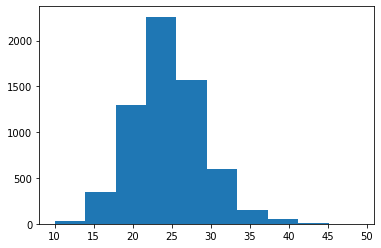

In [ ]:
plt.hist(Abstract_length)

#Tiền xử lý dữ liệu

In [ ]:
def get_stopwords_list(stop_file_path):
  with open(stop_file_path,'r',encoding="utf-8") as f:
    stopwords = f.readlines()
    stop_set = set(m.strip() for m in stopwords)
    return list(frozenset(stop_set))
stopwords = get_stopwords_list("/content/drive/MyDrive/DS300.M11/project/vietnamese-stopwords.txt")

In [ ]:
def pre_processing(text):
  text = text.lower()
  # xóa \xa0
  text = re.sub('\xa0',' ',text)
  # Xóa dấu chấm, phẩy, hỏi ở cuối câu
  text = re.sub(r"[\.,\?]+$-", " ", text)
  # Xóa tất cả dấu trong câu
  text = text.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("-", " ").replace("?", " ") \
        .replace("("," ").replace(")"," ") \
        .replace("%"," ").replace("+"," ") \
        .replace("="," ").replace("__"," ")
  text = text.strip()
  #tách từ
  text = ViTokenizer.tokenize(text)
  text = text.split()
  #xóa stopwords
  text = [w for w in text if w not in stopwords]
  text = " ".join(text)
  return text

#TfidfVectorizer

In [ ]:
contents = dataset[['NewsTitle','NewsAbstract']].agg(' '.join, axis=1)
#contents = dataset['NewsAbstract']
#contents = dataset['NewsTitle']

In [ ]:
contents

0       Người đàn ông 'nghiện' chế tạo máy bay mô hình...
1       Lời khuyên vàng khi chọn rèm cửa - VnExpress Đ...
2       Truyện tranh siêu nhân có giá 2,6 triệu USD - ...
3       Căn hộ chia không gian bằng cánh tủ - VnExpres...
4       10 phong cách thiết kế nhà nổi bật năm 2021 - ...
                              ...                        
6310    Cứu cô gái 18 tuổi bị đột quỵ - VnExpress Sức ...
6311    Covid-19 Hà Nội: Test nhanh dương tính, nhiều ...
6312    TP HCM kêu gọi nhà thuốc tư nhân chống dịch Co...
6313    Bệnh xá 30 năm tuổi trên đảo Trường Sa - VnExp...
6314    Cách tập thở, tăng thể lực cho F0 tại nhà - Vn...
Length: 6315, dtype: object

In [ ]:
topic = np.array(pd.get_dummies(dataset['Topic']))

In [ ]:
corpus = contents.apply(pre_processing)

In [ ]:
vectorizer = TfidfVectorizer()

In [ ]:
topic.shape

(6315, 9)

In [ ]:
overview_matrix = vectorizer.fit_transform(corpus).toarray()
overview_matrix_tfidf = np.hstack((overview_matrix,topic))

In [ ]:
cosine_similarity_matrix = cosine_similarity(overview_matrix_tfidf)

In [ ]:
mapping = pd.Series(dataset.index,index=dataset['NewsTitle'])
mapping

NewsTitle
Người đàn ông 'nghiện' chế tạo máy bay mô hình - VnExpress Đời sống       0
Lời khuyên vàng khi chọn rèm cửa - VnExpress Đời sống                     1
Truyện tranh siêu nhân có giá 2,6 triệu USD - VnExpress Đời sống          2
Căn hộ chia không gian bằng cánh tủ - VnExpress Đời sống                  3
10 phong cách thiết kế nhà nổi bật năm 2021 - VnExpress Đời sống          4
                                                                       ... 
Cứu cô gái 18 tuổi bị đột quỵ - VnExpress Sức khỏe                     6310
Covid-19 Hà Nội: Test nhanh dương tính, nhiều F0 tự đến viện           6311
TP HCM kêu gọi nhà thuốc tư nhân chống dịch Covid-19                   6312
Bệnh xá 30 năm tuổi trên đảo Trường Sa - VnExpress Sức khỏe            6313
Cách tập thở, tăng thể lực cho F0 tại nhà - VnExpress Sức khỏe         6314
Length: 6315, dtype: int64

In [ ]:
def get_newtitle(newsid):
  return dataset[dataset['NewsID']==newsid]['NewsTitle'].values[0]

def get_newid(newtitle):
  return dataset[dataset['NewsTitle']==newtitle]['NewsID'].values[0]

#word2vec

In [ ]:
word2vec_path = "/content/drive/MyDrive/DS300.M11/project/embedding/baomoi.window2.vn.model.bin.gz"
model_w2v = KeyedVectors.load_word2vec_format(word2vec_path,binary=True)

In [ ]:
vocab = model_w2v.wv.vocab

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [ ]:
max_len = 0
for sent in corpus:
  tok = sent.split()
  if(len(tok)>max_len):
    max_len = len(tok)
print(max_len)

46


In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(corpus)
tokenized_documents=tokenizer.texts_to_sequences(corpus)
tokenized_paded_documents=pad_sequences(tokenized_documents,maxlen=max_len,padding='post')
vocab_size=len(tokenizer.word_index)+1
print (tokenized_paded_documents[0])

[ 551  936 2189  185  153   44   93  442   34    1   51   48  314   44
   93  442   34  857   22   78    7  214   17   19  434  185  153  998
 1706  231    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [ ]:
embedding_matrix=np.zeros((vocab_size,300))
for word,i in tokenizer.word_index.items():
    if word in model_w2v:
        embedding_matrix[i]=model_w2v[word]

document_word_embeddings=np.zeros((len(tokenized_paded_documents),max_len,300))
for i in range(len(tokenized_paded_documents)):
    for j in range(len(tokenized_paded_documents[0])):
        document_word_embeddings[i][j]=embedding_matrix[tokenized_paded_documents[i][j]]
document_word_embeddings.shape

(6315, 46, 300)

In [ ]:
document_embeddings=np.zeros((len(tokenized_paded_documents),300))
words=vectorizer.get_feature_names()
for i in range(len(document_word_embeddings)):
  for j in range(len(words)):
    if words[j] in tokenizer.word_index.keys():
      document_embeddings[i]+=embedding_matrix[tokenizer.word_index[words[j]]]*overview_matrix[i][j]
print(document_embeddings.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(6315, 300)


In [ ]:
overview_w2v = cosine_similarity(document_embeddings)

In [ ]:
np.save('/content/drive/MyDrive/DS300.M11/project/w2v_similarity.npy',overview_w2v)

In [ ]:
w2v_similarity = load('/content/drive/MyDrive/DS300.M11/project/w2v_similarity.npy')

In [ ]:
w2v_similarity

array([[ 1.        ,  0.11799741, -0.11400331, ..., -0.01977316,
         0.20475593,  0.08364552],
       [ 0.11799741,  1.        , -0.02489175, ..., -0.23345207,
         0.22933033,  0.24388477],
       [-0.11400331, -0.02489175,  1.        , ...,  0.04392547,
         0.14944221,  0.01727033],
       ...,
       [-0.01977316, -0.23345207,  0.04392547, ...,  1.        ,
         0.10343423, -0.05999022],
       [ 0.20475593,  0.22933033,  0.14944221, ...,  0.10343423,
         1.        ,  0.19348127],
       [ 0.08364552,  0.24388477,  0.01727033, ..., -0.05999022,
         0.19348127,  1.        ]])

#FastText

In [ ]:
path = '/content/drive/MyDrive/DS300.M11/project/fasttext_similarity.npy'
from numpy import load
fasttext_similarity = load(path)
fasttext_similarity

array([[1.        , 0.74405742, 0.65834884, ..., 0.69940555, 0.74262241,
        0.6316404 ],
       [0.74405742, 1.        , 0.51186034, ..., 0.64465898, 0.65501582,
        0.66504744],
       [0.65834884, 0.51186034, 1.        , ..., 0.67096294, 0.62281734,
        0.49161743],
       ...,
       [0.69940555, 0.64465898, 0.67096294, ..., 1.        , 0.72078351,
        0.62316852],
       [0.74262241, 0.65501582, 0.62281734, ..., 0.72078351, 1.        ,
        0.62211386],
       [0.6316404 , 0.66504744, 0.49161743, ..., 0.62316852, 0.62211386,
        1.        ]])

In [ ]:
fasttext_similarity.shape

(6315, 6315)

# Jaccard

In [ ]:
def jaccard_set(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

#Demo

In [ ]:
def recommend_news(userid,newid,method ='tfidf'):
  title = get_newtitle(str(newid))
  new_index = mapping[title]
  print('Tiêu đề bài báo : ',title)
  print('')
  if method == 'tfidf':
    similarity_score = list(enumerate(cosine_similarity_matrix[new_index]))
  if method =='jaccard':
    jaccard_similarity = np.zeros(shape=(len(dataset)))
    for i in range(len(dataset)):
      jaccard_similarity[i] = jaccard_set(list(tokenized_documents[new_index]),list(tokenized_documents[i]))
    similarity_score = list(enumerate(jaccard_similarity))
  if method =='word2vec':
    similarity_score = list(enumerate(overview_w2v[new_index]))
  if method =='fasttext':
    similarity_score = list(enumerate(fasttext_similarity[new_index]))
  similarity_score = sorted(similarity_score, key = lambda x:x[1],reverse=True)
  similarity_score = similarity_score[1:10]
  recommendations = [(dataset['NewsTitle'].loc[index],score) for index,score in similarity_score]
  print('Danh sách top 10 các bài báo khuyến nghị dựa trên ' +str(method)+' cho user có id là {} : '.format(userid))
  print('')
  return recommendations

In [ ]:
recommend_news(userid =1002611542 ,newid = 4404506,method = 'word2vec')

#Đánh giá

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/DS300.M11/dataset/test_set.csv')

In [ ]:
def precision_recall(userid,threshold=0.5,method = 'tfidf'):
    """Return precision and recall at k metrics for each user"""
    id_true = test[test['UserID']==userid]['NewsID'].values[0].split()
    precision = 0
    recall = 0
    len_news = len(test[test['UserID']==userid]['NewsID'].values[0].split())/4
    for newid in test[test['UserID']==userid]['NewsID'].values[0].split():
      id_pred  = []
      for title,score in recommend_news(userid,newid,method):
        if score >=threshold:
          id_pred.append(get_newid(title))
      n_rel_and_rec_k = len(list(set(id_true).intersection(id_pred)))
      precision += n_rel_and_rec_k/len(id_pred) if id_pred!=[] else 0
      recall += n_rel_and_rec_k/len(id_true) if id_true!=[] else 0
    return precision/len_news,recall/len_news

In [ ]:
'''for method in ['tfidf','word2vec','fasttext']:
  precision = [0 for i in range(len(test))]
  recall = [0 for i in range(len(test))]
  for i in range(len(test)):
    userid = test['UserID'].loc[i]
    precision[i], recall[i] = precision_recall(userid,method = method)
  print('Precision score of {}'.format(method),np.round(np.mean(precision)*100,2))
  print('Recall score of {}'.format(method),np.round(np.mean(recall)*100,2))'''